# Hybrid Rule-Based Regime + ML Regression Strategy

## Architecture
1. **Rule-Based Regime Detection**: Use proven momentum-based method (MACD + FD) on daily timeframe
2. **ML Regression Model**: Predict risk-adjusted forward returns within Bull regimes
3. **Backtesting**: Compare hybrid regression vs pure rule-based strategy

## Key Innovation
- **Regression instead of Classification**: Predicts continuous returns, not binary yes/no
- **Risk-Adjusted Target**: Net return accounting for fees and stop loss
- **Direct threshold**: Enter when predicted return > 2% (no probability calibration)
- **Better training signal**: Every data point contributes magnitude information

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Import PyCaret for comprehensive regression model comparison
from pycaret.regression import *

plt.style.use('seaborn-v0_8')
np.random.seed(42)

print("Starting Hybrid Rule-Based Regime + ML Regression Strategy")
print("With PyCaret for comprehensive model comparison")
print("=" * 70)

Starting Hybrid Rule-Based Regime + ML Regression Strategy
With PyCaret for comprehensive model comparison


## 1. Load Data and Configuration

In [13]:
# Strategy configuration (easy to edit)
CONFIG = {
    'stop_loss_pct': 0.04,         # 4% stop loss
    'lookforward_hours': 24,       # Look forward 24 hours for target
    'commission': 0.0075,          # 0.75% commission
    'regime_timeframe': '1D',      # Daily regime detection
    'train_test_split': 0.70,      # 70% train, 30% test
    'min_entry_return': 0.05,      # Minimum predicted return to enter (5% - INCREASED)
    'use_gross_target': True,      # Train on gross returns (no fee adjustment)
}

print("Strategy Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

# Load 1-minute data
df = pd.read_csv('../data/BTCUSD_2023_1min_cleaned.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp').sort_index()

# Clean unnecessary columns
cols_to_drop = [col for col in df.columns if 'Unnamed' in col]
df = df.drop(columns=cols_to_drop, errors='ignore')

print(f"\nData loaded: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Available features: {list(df.columns)}")

Strategy Configuration:
  stop_loss_pct: 0.04
  lookforward_hours: 24
  commission: 0.0075
  regime_timeframe: 1D
  train_test_split: 0.7
  min_entry_return: 0.05
  use_gross_target: True

Data loaded: (434438, 25)
Date range: 2023-02-10 00:00:00 to 2023-12-31 14:27:00
Available features: ['Open', 'High', 'Low', 'Close', 'Volume', 'ema_7d', 'ema_20d', 'ema_30d', 'sma_7d', 'sma_20d', 'sma_30d', 'macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26', 'rsi_14d', 'bb_mid_20d', 'bb_upper_20d', 'bb_lower_20d', 'atr_14d', 'fd_14d', 'future_close', 'future_return', 'future_trend', 'fd_7d', 'fd_30d']


## 2. Rule-Based Regime Classification Pipeline

Using proven momentum-based method from `regime_classification_enhanced.ipynb`:
- Daily timeframe (1D) for stable regime detection
- MACD + Fractal Dimension momentum indicators
- Price momentum confirmation

In [14]:
def classify_momentum_regimes_daily(df_1min):
    """
    Rule-based momentum regime classification on daily timeframe
    Returns: DataFrame with regime column applied to all 1-minute bars
    """
    # Aggregate to daily
    agg_dict = {
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    }
    
    # Include existing indicators if available
    for col in ['macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26', 'rsi_14d', 'fd_14d', 'fd_7d', 'fd_30d']:
        if col in df_1min.columns:
            agg_dict[col] = 'last'
    
    df_daily = df_1min.resample('1D').agg(agg_dict).dropna()
    
    # Calculate daily returns and volatility
    df_daily['return'] = df_daily['Close'].pct_change()
    df_daily['return_5p'] = df_daily['Close'].pct_change(5)
    df_daily['volatility'] = df_daily['return'].rolling(5).std()
    
    # Initialize regime conditions
    bull_condition = pd.Series(False, index=df_daily.index)
    bear_condition = pd.Series(False, index=df_daily.index)
    
    # MACD-based momentum
    if 'macd_hist_12_26' in df_daily.columns and 'macd_12_26' in df_daily.columns:
        macd_bull = (
            (df_daily['macd_12_26'] > df_daily['macd_sig_12_26']) & 
            (df_daily['macd_hist_12_26'] > 0) &
            (df_daily['macd_hist_12_26'] > df_daily['macd_hist_12_26'].shift(1))
        )
        
        macd_bear = (
            (df_daily['macd_12_26'] < df_daily['macd_sig_12_26']) & 
            (df_daily['macd_hist_12_26'] < 0) &
            (df_daily['macd_hist_12_26'] < df_daily['macd_hist_12_26'].shift(1))
        )
        
        bull_condition |= macd_bull
        bear_condition |= macd_bear
    
    # Fractal Dimension-based regime
    if 'fd_14d' in df_daily.columns:
        if 'fd_7d' in df_daily.columns and 'fd_30d' in df_daily.columns:
            fd_bull = (df_daily['fd_7d'] > df_daily['fd_30d']) & (df_daily['fd_14d'] > 1.3)
            fd_bear = (df_daily['fd_7d'] < df_daily['fd_30d']) & (df_daily['fd_14d'] > 1.5)
        else:
            fd_ma = df_daily['fd_14d'].rolling(5).mean()
            fd_trend = df_daily['fd_14d'] - fd_ma
            fd_bull = (fd_trend > 0) & (df_daily['fd_14d'] > df_daily['fd_14d'].rolling(10).quantile(0.6))
            fd_bear = df_daily['fd_14d'] > df_daily['fd_14d'].rolling(20).quantile(0.8)
        
        bull_condition |= fd_bull
        bear_condition |= fd_bear
    
    # Price momentum confirmation
    if 'return_5p' in df_daily.columns:
        price_bull = df_daily['return_5p'] > df_daily['return_5p'].rolling(10).quantile(0.7)
        price_bear = df_daily['return_5p'] < df_daily['return_5p'].rolling(10).quantile(0.3)
        
        bull_condition &= price_bull
        bear_condition &= price_bear
    
    # Assign regimes: 2=Bull, 1=Sideways, 0=Bear
    df_daily['regime'] = np.where(bull_condition, 2, np.where(bear_condition, 0, 1))
    
    # Map regimes back to 1-minute data
    df_result = df_1min.copy()
    df_result['period'] = df_result.index.floor('D')
    
    regime_map = dict(zip(df_daily.index, df_daily['regime']))
    df_result['regime'] = df_result['period'].map(regime_map)
    df_result['regime'] = df_result['regime'].fillna(method='ffill')
    df_result = df_result.drop('period', axis=1)
    
    return df_result, df_daily

# Apply regime classification
print("Applying rule-based momentum regime classification...")
df_with_regimes, df_daily_regimes = classify_momentum_regimes_daily(df)

# Show regime distribution
regime_names = {0: 'Bear', 1: 'Sideways', 2: 'Bull'}
regime_counts = df_with_regimes['regime'].value_counts().sort_index()

print("\nRegime Distribution (1-minute data):")
for regime, count in regime_counts.items():
    pct = count / len(df_with_regimes) * 100
    print(f"  {regime_names[regime]:>8} ({regime}): {count:>6,} bars ({pct:>5.1f}%)")

print(f"\nDaily regime periods: {len(df_daily_regimes)}")
print(f"Regime changes: {(df_daily_regimes['regime'].diff() != 0).sum()}")

Applying rule-based momentum regime classification...

Regime Distribution (1-minute data):
      Bear (0): 74,605 bars ( 17.2%)
  Sideways (1): 296,485 bars ( 68.2%)
      Bull (2): 63,348 bars ( 14.6%)

Daily regime periods: 325
Regime changes: 71


## 3. Create Regression Target: Gross Forward Return (NO Fee Adjustment)

**NEW APPROACH - Train on GROSS returns**:
- Target = Raw return achievable in next 24hrs (NO fee subtraction)
- If stop loss hit: return = -4% (raw stop loss, no fees)
- Otherwise: return = max achievable gain (capped at 20%)
- **Fees applied ONLY during backtesting, NOT in training**
- This prevents model from learning pessimistic bias

Only create targets for Bull regime periods (regime == 2)

In [15]:
def create_regression_target(df, stop_loss_pct=0.04, lookforward_hours=24, use_gross=True):
    """
    Create regression target: forward return
    
    Target = return achievable in next N hours
    - If stop loss hit: return = -stop_loss (NO fees if use_gross=True)
    - Otherwise: return = best achievable gain (NO fees if use_gross=True)
    - Fees applied during backtesting, not training
    """
    df = df.copy()
    lookforward_bars = lookforward_hours * 60  # Convert hours to minutes
    
    targets = []
    
    for i in range(len(df)):
        if i + lookforward_bars >= len(df):
            # Not enough future data
            targets.append(np.nan)
            continue
        
        entry_price = df.iloc[i]['Close']
        future_window = df.iloc[i+1:i+1+lookforward_bars]
        
        # Calculate max upside and downside
        max_gain = (future_window['High'].max() - entry_price) / entry_price
        max_loss = (future_window['Low'].min() - entry_price) / entry_price
        
        # Check if stop loss would be hit
        if max_loss <= -stop_loss_pct:
            # Stop loss exit (gross, no fees)
            gross_return = -stop_loss_pct
        else:
            # Exit at best available price (cap at 20% for outlier control)
            gross_return = min(max_gain, 0.20)
        
        targets.append(gross_return)
    
    df['ml_target'] = targets
    return df

print("Creating regression target: GROSS forward return (no fee adjustment)...")
print(f"Target: Gross return in {CONFIG['lookforward_hours']}hrs (capped at stop loss: {CONFIG['stop_loss_pct']*100:.0f}%)")
print(f"Fees will be applied during backtesting ONLY")

df_with_labels = create_regression_target(
    df_with_regimes,
    stop_loss_pct=CONFIG['stop_loss_pct'],
    lookforward_hours=CONFIG['lookforward_hours'],
    use_gross=CONFIG['use_gross_target']
)

# Show target distribution
print("\nRegression Target Distribution (All Data):")
valid_targets = df_with_labels['ml_target'].dropna()
print(f"  Count: {len(valid_targets):,}")
print(f"  Mean: {valid_targets.mean():.4f} ({valid_targets.mean()*100:.2f}%)")
print(f"  Std: {valid_targets.std():.4f}")
print(f"  Min: {valid_targets.min():.4f} ({valid_targets.min()*100:.2f}%)")
print(f"  Max: {valid_targets.max():.4f} ({valid_targets.max()*100:.2f}%)")
print(f"  Median: {valid_targets.median():.4f} ({valid_targets.median()*100:.2f}%)")

# Show target distribution within Bull regimes only
bull_data = df_with_labels[df_with_labels['regime'] == 2]
bull_targets = bull_data['ml_target'].dropna()
print("\nRegression Target Distribution (Bull Regime Only):")
print(f"  Count: {len(bull_targets):,}")
print(f"  Mean: {bull_targets.mean():.4f} ({bull_targets.mean()*100:.2f}%)")
print(f"  Std: {bull_targets.std():.4f}")
print(f"  Min: {bull_targets.min():.4f} ({bull_targets.min()*100:.2f}%)")
print(f"  Max: {bull_targets.max():.4f} ({bull_targets.max()*100:.2f}%)")
print(f"  Median: {bull_targets.median():.4f} ({bull_targets.median()*100:.2f}%)")
print(f"  Positive returns: {(bull_targets > 0).sum():,} ({(bull_targets > 0).sum()/len(bull_targets)*100:.1f}%)")
print(f"  Returns > 5%: {(bull_targets > 0.05).sum():,} ({(bull_targets > 0.05).sum()/len(bull_targets)*100:.1f}%)")
print(f"  Returns > 10%: {(bull_targets > 0.10).sum():,} ({(bull_targets > 0.10).sum()/len(bull_targets)*100:.1f}%)")

print(f"\nBull regime bars: {len(bull_data):,}")
print(f"Valid targets in Bull: {len(bull_targets):,}")

Creating regression target: GROSS forward return (no fee adjustment)...
Target: Gross return in 24hrs (capped at stop loss: 4%)
Fees will be applied during backtesting ONLY

Regression Target Distribution (All Data):
  Count: 432,998
  Mean: 0.0151 (1.51%)
  Std: 0.0260
  Min: -0.0400 (-4.00%)
  Max: 0.2000 (20.00%)
  Median: 0.0109 (1.09%)

Regression Target Distribution (Bull Regime Only):
  Count: 63,348
  Mean: 0.0274 (2.74%)
  Std: 0.0298
  Min: -0.0400 (-4.00%)
  Max: 0.1648 (16.48%)
  Median: 0.0184 (1.84%)
  Positive returns: 62,465 (98.6%)
  Returns > 5%: 11,293 (17.8%)
  Returns > 10%: 1,872 (3.0%)

Bull regime bars: 63,348
Valid targets in Bull: 63,348


## 4. Prepare Features for ML Training

Use existing features from dataset (no new feature engineering)

In [16]:
# Identify feature columns (exclude target, regime, and OHLCV)
exclude_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'regime', 'ml_target', 
                'future_close', 'future_return', 'future_trend']  # Exclude any future-looking features

feature_cols = [col for col in df_with_labels.columns if col not in exclude_cols]

print(f"Available features for ML: {len(feature_cols)}")
print(f"Features: {feature_cols}")

# Prepare training data (only Bull regime periods)
train_data = df_with_labels[
    (df_with_labels['regime'] == 2) &  # Bull regime only
    (df_with_labels['ml_target'].notna())  # Valid labels
].copy()

# Remove any rows with NaN in features
train_data_clean = train_data[feature_cols + ['ml_target']].dropna()

print(f"\nTraining dataset size: {len(train_data_clean):,} samples")
print(f"Target mean: {train_data_clean['ml_target'].mean():.4f} ({train_data_clean['ml_target'].mean()*100:.2f}%)")
print(f"Target std: {train_data_clean['ml_target'].std():.4f}")
print(f"Positive returns: {(train_data_clean['ml_target'] > 0).sum():,} ({(train_data_clean['ml_target'] > 0).sum()/len(train_data_clean)*100:.1f}%)")
print(f"Returns > 2%: {(train_data_clean['ml_target'] > 0.02).sum():,} ({(train_data_clean['ml_target'] > 0.02).sum()/len(train_data_clean)*100:.1f}%)")

# Split into train/test (temporal split)
split_idx = int(len(train_data_clean) * CONFIG['train_test_split'])
train_set = train_data_clean.iloc[:split_idx]
test_set = train_data_clean.iloc[split_idx:]

X_train = train_set[feature_cols]
y_train = train_set['ml_target']
X_test = test_set[feature_cols]
y_test = test_set['ml_target']

print(f"\nTrain set: {len(X_train):,} samples")
print(f"  Mean target: {y_train.mean():.4f} ({y_train.mean()*100:.2f}%)")
print(f"  Positive: {(y_train > 0).sum():,} ({(y_train > 0).sum()/len(y_train)*100:.1f}%)")

print(f"\nTest set:  {len(X_test):,} samples")
print(f"  Mean target: {y_test.mean():.4f} ({y_test.mean()*100:.2f}%)")
print(f"  Positive: {(y_test > 0).sum():,} ({(y_test > 0).sum()/len(y_test)*100:.1f}%)")

print(f"\nTrain period: {train_set.index.min()} to {train_set.index.max()}")
print(f"Test period:  {test_set.index.min()} to {test_set.index.max()}")

Available features for ML: 17
Features: ['ema_7d', 'ema_20d', 'ema_30d', 'sma_7d', 'sma_20d', 'sma_30d', 'macd_12_26', 'macd_sig_12_26', 'macd_hist_12_26', 'rsi_14d', 'bb_mid_20d', 'bb_upper_20d', 'bb_lower_20d', 'atr_14d', 'fd_14d', 'fd_7d', 'fd_30d']

Training dataset size: 63,348 samples
Target mean: 0.0274 (2.74%)
Target std: 0.0298
Positive returns: 62,465 (98.6%)
Returns > 2%: 29,865 (47.1%)

Train set: 44,343 samples
  Mean target: 0.0243 (2.43%)
  Positive: 43,569 (98.3%)

Test set:  19,005 samples
  Mean target: 0.0345 (3.45%)
  Positive: 18,896 (99.4%)

Train period: 2023-03-14 00:00:00 to 2023-10-02 16:39:00
Test period:  2023-10-02 16:40:00 to 2023-12-06 23:59:00


## 5. Feature Selection for Regression

Use stepwise selection approach adapted for regression models

In [17]:
def calculate_bic_regression(n, mse, num_params):
    """Calculate BIC for regression model selection"""
    return n * np.log(mse) + num_params * np.log(n)

def forward_selection_regression(X, y, max_features=None):
    """Forward stepwise selection using BIC for regression"""
    n_samples = len(X)
    remaining_features = list(X.columns)
    selected_features = []
    
    if max_features is None:
        max_features = len(remaining_features)
    
    best_bic = np.inf
    
    print("Forward Selection Progress (Regression):")
    
    for i in range(max_features):
        if not remaining_features:
            break
        
        bic_scores = {}
        
        for feature in remaining_features:
            candidate_features = selected_features + [feature]
            
            # Scale features
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X[candidate_features])
            
            # Fit regression model
            model = Ridge(alpha=1.0, random_state=42)
            model.fit(X_scaled, y)
            
            # Calculate BIC using MSE
            y_pred = model.predict(X_scaled)
            mse = mean_squared_error(y, y_pred)
            bic = calculate_bic_regression(n_samples, mse, len(candidate_features))
            bic_scores[feature] = bic
        
        # Select feature with lowest BIC
        best_feature = min(bic_scores, key=bic_scores.get)
        best_feature_bic = bic_scores[best_feature]
        
        # Stop if BIC is not improving
        if best_feature_bic >= best_bic:
            print(f"  Stopping: BIC not improving ({best_feature_bic:.2f} >= {best_bic:.2f})")
            break
        
        # Add feature
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        best_bic = best_feature_bic
        
        if (i + 1) % 5 == 0 or i == 0:
            print(f"  Step {i+1}: Added '{best_feature}', BIC={best_bic:.2f}, Features={len(selected_features)}")
    
    return selected_features

# Apply forward selection
print("Starting feature selection for regression models...")
print(f"Initial features: {len(feature_cols)}")
print("="*70)

selected_features = forward_selection_regression(X_train, y_train, max_features=50)

print(f"\n{'='*70}")
print(f"Feature Selection Complete")
print(f"Selected features: {len(selected_features)} (reduction: {(1 - len(selected_features)/len(feature_cols))*100:.1f}%)")
print(f"\nSelected features:")
for i, feat in enumerate(selected_features, 1):
    print(f"  {i:2}. {feat}")

Starting feature selection for regression models...
Initial features: 17
Forward Selection Progress (Regression):
  Step 1: Added 'sma_30d', BIC=-329331.22, Features=1
  Step 5: Added 'sma_20d', BIC=-337777.23, Features=5
  Step 10: Added 'macd_sig_12_26', BIC=-342905.53, Features=10
  Step 15: Added 'macd_12_26', BIC=-344517.44, Features=15
  Stopping: BIC not improving (-344512.19 >= -344517.44)

Feature Selection Complete
Selected features: 15 (reduction: 11.8%)

Selected features:
   1. sma_30d
   2. fd_7d
   3. rsi_14d
   4. fd_30d
   5. sma_20d
   6. fd_14d
   7. atr_14d
   8. ema_30d
   9. macd_hist_12_26
  10. macd_sig_12_26
  11. bb_lower_20d
  12. sma_7d
  13. ema_7d
  14. bb_upper_20d
  15. macd_12_26


## 6. Train Regression Models with PyCaret

Use PyCaret to automatically test multiple regression algorithms and select the best model

In [18]:
# Prepare data for PyCaret
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Create training and test DataFrames with target
train_df_pycaret = X_train_selected.copy()
train_df_pycaret['ml_target'] = y_train.values

test_df_pycaret = X_test_selected.copy()
test_df_pycaret['ml_target'] = y_test.values

print(f"Training set for PyCaret: {train_df_pycaret.shape}")
print(f"Test set for PyCaret: {test_df_pycaret.shape}")
print(f"Target column: ml_target")
print(f"Features: {selected_features}")

# Setup PyCaret regression environment
print("\n" + "="*70)
print("Setting up PyCaret Regression Environment...")
print("="*70)

reg_setup = setup(
    data=train_df_pycaret,
    test_data=test_df_pycaret,
    target='ml_target',
    session_id=42,
    normalize=True,
    verbose=False,
    html=False,
    system_log=False
)

print("\nPyCaret setup complete!")

# Compare multiple regression models
print("\n" + "="*70)
print("Comparing Multiple Regression Models...")
print("Testing: Linear, Ridge, Lasso, ElasticNet, KNN, Decision Tree,")
print("         Random Forest, Extra Trees, AdaBoost, Gradient Boosting,")
print("         XGBoost, LightGBM, CatBoost, and more...")
print("="*70 + "\n")

# Compare models - this will test ALL available regression models
best_models = compare_models(
    n_select=10,  # Select top 10 models
    sort='MAE',   # Sort by Mean Absolute Error (better for our use case)
    turbo=False,  # Full training (not turbo mode)
    errors='ignore'
)

# Get comparison results
comparison_results = pull()
print("\n" + "="*70)
print("TOP 10 REGRESSION MODELS BY MAE")
print("="*70)
print(comparison_results.to_string())

# Select best model (lowest MAE)
best_model = best_models[0]
best_model_name = type(best_model).__name__

print("\n" + "="*70)
print(f"BEST MODEL SELECTED: {best_model_name}")
print("="*70)

# Get detailed predictions on test set
print("\nEvaluating best model on test set...")
test_predictions = predict_model(best_model, data=test_df_pycaret)

# Calculate custom metrics
y_test_actual = test_predictions['ml_target'].values
y_test_pred = test_predictions['prediction_label'].values

test_mse = mean_squared_error(y_test_actual, y_test_pred)
test_mae = mean_absolute_error(y_test_actual, y_test_pred)
test_r2 = r2_score(y_test_actual, y_test_pred)

print(f"\nBest Model ({best_model_name}) Test Metrics:")
print(f"  Test MSE: {test_mse:.6f}")
print(f"  Test MAE: {test_mae:.6f} ({test_mae*100:.2f}%)")
print(f"  Test R²:  {test_r2:.4f}")
print(f"\nPrediction Distribution:")
print(f"  Mean: {y_test_pred.mean():.4f} ({y_test_pred.mean()*100:.2f}%)")
print(f"  Std:  {y_test_pred.std():.4f}")
print(f"  Min:  {y_test_pred.min():.4f} ({y_test_pred.min()*100:.2f}%)")
print(f"  Max:  {y_test_pred.max():.4f} ({y_test_pred.max()*100:.2f}%)")
print(f"  Median: {np.median(y_test_pred):.4f} ({np.median(y_test_pred)*100:.2f}%)")

# Count predictions above thresholds
min_entry = CONFIG['min_entry_return']
print(f"\nEntry Signal Analysis:")
print(f"  Predictions > {min_entry*100:.0f}%: {(y_test_pred > min_entry).sum():,} ({(y_test_pred > min_entry).sum()/len(y_test_pred)*100:.1f}%)")
print(f"  Predictions > 3%: {(y_test_pred > 0.03).sum():,} ({(y_test_pred > 0.03).sum()/len(y_test_pred)*100:.1f}%)")
print(f"  Predictions > 10%: {(y_test_pred > 0.10).sum():,} ({(y_test_pred > 0.10).sum()/len(y_test_pred)*100:.1f}%)")
print(f"  Negative predictions: {(y_test_pred < 0).sum():,} ({(y_test_pred < 0).sum()/len(y_test_pred)*100:.1f}%)")

# Compare actual vs predicted means
print(f"\nActual vs Predicted Comparison:")
print(f"  Actual mean return: {y_test_actual.mean():.4f} ({y_test_actual.mean()*100:.2f}%)")
print(f"  Predicted mean return: {y_test_pred.mean():.4f} ({y_test_pred.mean()*100:.2f}%)")
print(f"  Prediction bias: {(y_test_pred.mean() - y_test_actual.mean())*100:.2f}%")

# Finalize best model for deployment
best_model_final = finalize_model(best_model)
print(f"\nModel finalized and ready for backtesting!")

# Store for backtesting (need to create scaler for feature scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)

print(f"\nScaler fitted on training data for backtesting")

Training set for PyCaret: (44343, 16)
Test set for PyCaret: (19005, 16)
Target column: ml_target
Features: ['sma_30d', 'fd_7d', 'rsi_14d', 'fd_30d', 'sma_20d', 'fd_14d', 'atr_14d', 'ema_30d', 'macd_hist_12_26', 'macd_sig_12_26', 'bb_lower_20d', 'sma_7d', 'ema_7d', 'bb_upper_20d', 'macd_12_26']

Setting up PyCaret Regression Environment...

PyCaret setup complete!

Comparing Multiple Regression Models...
Testing: Linear, Ridge, Lasso, ElasticNet, KNN, Decision Tree,
         Random Forest, Extra Trees, AdaBoost, Gradient Boosting,
         XGBoost, LightGBM, CatBoost, and more...



                                      Model          MAE           MSE  \
et                    Extra Trees Regressor       0.0180  7.000000e-04   
en                              Elastic Net       0.0200  7.000000e-04   
dummy                       Dummy Regressor       0.0200  7.000000e-04   
llar           Lasso Least Angle Regression       0.0200  7.000000e-04   
lasso                      Lasso Regression       0.0200  7.000000e-04   
omp             Orthogonal Matching Pursuit       0.0206  7.000000e-04   
gbr             Gradient Boosting Regressor       0.0217  1.100000e-03   
dt                  Decision Tree Regressor       0.0228  1.000000e-03   
rf                  Random Forest Regressor       0.0228  1.100000e-03   
knn                   K Neighbors Regressor       0.0234  1.100000e-03   
ada                      AdaBoost Regressor       0.0240  1.200000e-03   
par            Passive Aggressive Regressor       0.0240  1.100000e-03   
lightgbm    Light Gradient Boosting Ma

## 7. Backtesting Framework

In [19]:
class FeeAwareExitManager:
    """Exit logic with transaction fees"""
    
    def __init__(self, commission=0.0075, slippage=0.0001):
        self.commission = commission
        self.slippage = slippage
        self.total_cost = commission + slippage
        self.round_trip_cost = self.total_cost * 2
        
        print(f"Fee-Aware Exit Manager:")
        print(f"  Commission: {commission*100:.2f}%")
        print(f"  Round-trip cost: {self.round_trip_cost*100:.2f}%")
    
    def calculate_net_pnl(self, entry_price, exit_price):
        """Calculate P&L after fees"""
        gross_return = (exit_price - entry_price) / entry_price
        net_return = gross_return - self.round_trip_cost
        return net_return
    
    def should_exit(self, entry_price, current_price, entry_regime, current_regime, stop_loss_pct=0.04):
        """Determine if position should be exited"""
        net_pnl = self.calculate_net_pnl(entry_price, current_price)
        
        # Rule 1: Stop loss
        if net_pnl <= -stop_loss_pct:
            return True, f"Stop loss: {net_pnl:.2%}"
        
        # Rule 2: Regime change
        if current_regime != entry_regime:
            return True, f"Regime change: {entry_regime}->{current_regime}, P&L: {net_pnl:.2%}"
        
        return False, f"Hold (P&L: {net_pnl:.2%})"

fee_manager = FeeAwareExitManager(commission=CONFIG['commission'])

Fee-Aware Exit Manager:
  Commission: 0.75%
  Round-trip cost: 1.52%


In [20]:
def backtest_hybrid_regression(df, ml_model, selected_features, fee_manager, stop_loss=0.04, min_return=0.02, use_pycaret=True):
    """
    Backtest hybrid rule-based regime + ML regression strategy
    Uses ML predicted return threshold for entry
    
    Args:
        use_pycaret: If True, use PyCaret's predict_model format; else use sklearn format
    """
    capital = 10000
    position = None
    trades = []
    equity_curve = []
    ml_predictions_log = []  # Track ML predictions for debugging
    
    for i in range(len(df)):
        row = df.iloc[i]
        timestamp = row.name
        price = row['Close']
        regime = row['regime']
        
        # Check exit conditions if in position
        if position is not None:
            should_exit, exit_reason = fee_manager.should_exit(
                position['entry_price'],
                price,
                position['entry_regime'],
                regime,
                stop_loss
            )
            
            if should_exit:
                # Exit position
                exit_return = fee_manager.calculate_net_pnl(position['entry_price'], price)
                capital *= (1 + exit_return)
                
                trades.append({
                    'entry_time': position['entry_time'],
                    'exit_time': timestamp,
                    'entry_price': position['entry_price'],
                    'exit_price': price,
                    'return_pct': exit_return * 100,
                    'exit_reason': exit_reason,
                    'regime': position['entry_regime'],
                    'predicted_return': position.get('predicted_return', None)
                })
                
                position = None
        
        # Check entry conditions if not in position
        if position is None and regime == 2:  # Bull regime only
            # Prepare features for ML prediction
            try:
                features_df = pd.DataFrame([row[selected_features].values], columns=selected_features)
                
                if not features_df.isnull().any().any():
                    # Get predicted return
                    if use_pycaret:
                        # PyCaret prediction
                        pred_df = predict_model(ml_model, data=features_df)
                        predicted_return = pred_df['prediction_label'].iloc[0]
                    else:
                        # Sklearn prediction (with scaler)
                        features_scaled = scaler.transform(features_df)
                        predicted_return = ml_model.predict(features_scaled)[0]
                    
                    ml_predictions_log.append({'timestamp': timestamp, 'predicted_return': predicted_return})
                    
                    # Enter if predicted return exceeds minimum threshold
                    if predicted_return >= min_return:
                        position = {
                            'entry_time': timestamp,
                            'entry_price': price,
                            'entry_regime': regime,
                            'predicted_return': predicted_return
                        }
            except:
                pass  # Skip if features not available
        
        equity_curve.append(capital)
    
    # Close any open position at end
    if position is not None:
        final_price = df.iloc[-1]['Close']
        exit_return = fee_manager.calculate_net_pnl(position['entry_price'], final_price)
        capital *= (1 + exit_return)
        
        trades.append({
            'entry_time': position['entry_time'],
            'exit_time': df.index[-1],
            'entry_price': position['entry_price'],
            'exit_price': final_price,
            'return_pct': exit_return * 100,
            'exit_reason': 'End of backtest',
            'regime': position['entry_regime'],
            'predicted_return': position.get('predicted_return', None)
        })
    
    return {
        'final_capital': capital,
        'total_return': (capital - 10000) / 10000 * 100,
        'trades': trades,
        'equity_curve': equity_curve,
        'num_trades': len(trades),
        'ml_predictions': ml_predictions_log
    }

def backtest_rule_based_bull(df, fee_manager, stop_loss=0.04):
    """
    Backtest pure rule-based Bull regime strategy (benchmark)
    """
    capital = 10000
    position = None
    trades = []
    equity_curve = []
    
    for i in range(len(df)):
        row = df.iloc[i]
        timestamp = row.name
        price = row['Close']
        regime = row['regime']
        
        # Check exit conditions
        if position is not None:
            should_exit, exit_reason = fee_manager.should_exit(
                position['entry_price'],
                price,
                position['entry_regime'],
                regime,
                stop_loss
            )
            
            if should_exit:
                exit_return = fee_manager.calculate_net_pnl(position['entry_price'], price)
                capital *= (1 + exit_return)
                
                trades.append({
                    'entry_time': position['entry_time'],
                    'exit_time': timestamp,
                    'entry_price': position['entry_price'],
                    'exit_price': price,
                    'return_pct': exit_return * 100,
                    'exit_reason': exit_reason,
                    'regime': position['entry_regime']
                })
                
                position = None
        
        # Entry: Simply enter on Bull regime start
        if position is None and regime == 2:
            # Only enter if this is start of Bull regime (regime changed)
            if i == 0 or df.iloc[i-1]['regime'] != 2:
                position = {
                    'entry_time': timestamp,
                    'entry_price': price,
                    'entry_regime': regime
                }
        
        equity_curve.append(capital)
    
    # Close any open position
    if position is not None:
        final_price = df.iloc[-1]['Close']
        exit_return = fee_manager.calculate_net_pnl(position['entry_price'], final_price)
        capital *= (1 + exit_return)
        
        trades.append({
            'entry_time': position['entry_time'],
            'exit_time': df.index[-1],
            'entry_price': position['entry_price'],
            'exit_price': final_price,
            'return_pct': exit_return * 100,
            'exit_reason': 'End of backtest',
            'regime': position['entry_regime']
        })
    
    return {
        'final_capital': capital,
        'total_return': (capital - 10000) / 10000 * 100,
        'trades': trades,
        'equity_curve': equity_curve,
        'num_trades': len(trades)
    }

print("Backtesting strategies defined with PyCaret regression-based entry")

Backtesting strategies defined with PyCaret regression-based entry


## 8. Run Backtests

Compare:
1. **Hybrid Regression**: Rule-based regime + ML predicted returns
2. **Rule-Based Bull**: Pure rule-based (enter at Bull regime start)

In [21]:
# Prepare test data (same period as ML test set)
test_start = test_set.index.min()
test_end = test_set.index.max()
df_backtest = df_with_labels.loc[test_start:test_end].copy()

print(f"Backtesting period: {test_start} to {test_end}")
print(f"Total bars: {len(df_backtest):,}")
print(f"Bull regime bars: {(df_backtest['regime'] == 2).sum():,}")
print(f"Minimum Entry Return: {CONFIG['min_entry_return']*100:.0f}%")
print("\n" + "="*70)

# Backtest 1: Hybrid Regression Strategy with PyCaret Model
print("\nBACKTEST 1: HYBRID (Rule-Based Regime + ML Regression with PyCaret)")
print("="*70)
hybrid_results = backtest_hybrid_regression(
    df_backtest,
    best_model_final,  # Use PyCaret finalized model
    selected_features,
    fee_manager,
    stop_loss=CONFIG['stop_loss_pct'],
    min_return=CONFIG['min_entry_return'],
    use_pycaret=True  # Use PyCaret prediction format
)

print(f"\nHybrid Regression Strategy Results:")
print(f"  Final Capital: ${hybrid_results['final_capital']:.2f}")
print(f"  Total Return: {hybrid_results['total_return']:.2f}%")
print(f"  Number of Trades: {hybrid_results['num_trades']}")

# Analyze ML prediction distribution
ml_preds_df = pd.DataFrame(hybrid_results['ml_predictions'])
if len(ml_preds_df) > 0:
    print(f"\nML Prediction Statistics (Bull Regime):") 
    print(f"  Total predictions: {len(ml_preds_df):,}")
    print(f"  Mean prediction: {ml_preds_df['predicted_return'].mean():.4f} ({ml_preds_df['predicted_return'].mean()*100:.2f}%)")
    print(f"  Std prediction: {ml_preds_df['predicted_return'].std():.4f}")
    print(f"  Min prediction: {ml_preds_df['predicted_return'].min():.4f} ({ml_preds_df['predicted_return'].min()*100:.2f}%)")
    print(f"  Max prediction: {ml_preds_df['predicted_return'].max():.4f} ({ml_preds_df['predicted_return'].max()*100:.2f}%)")
    print(f"  Predictions > {CONFIG['min_entry_return']*100:.0f}%: {(ml_preds_df['predicted_return'] >= CONFIG['min_entry_return']).sum():,}")
    print(f"  Predictions > 3%: {(ml_preds_df['predicted_return'] >= 0.03).sum():,}")
    print(f"  Predictions > 5%: {(ml_preds_df['predicted_return'] >= 0.05).sum():,}")
    print(f"  Predictions > 10%: {(ml_preds_df['predicted_return'] >= 0.10).sum():,}")

if hybrid_results['num_trades'] > 0:
    trades_df = pd.DataFrame(hybrid_results['trades'])
    winners = trades_df[trades_df['return_pct'] > 0]
    losers = trades_df[trades_df['return_pct'] <= 0]
    
    print(f"\nTrade Performance:")
    print(f"  Winners: {len(winners)} ({len(winners)/len(trades_df)*100:.1f}%)")
    print(f"  Losers: {len(losers)} ({len(losers)/len(trades_df)*100:.1f}%)")
    print(f"  Average Win: {winners['return_pct'].mean():.2f}%" if len(winners) > 0 else "  Average Win: N/A")
    print(f"  Average Loss: {losers['return_pct'].mean():.2f}%" if len(losers) > 0 else "  Average Loss: N/A")
    print(f"  Best Trade: {trades_df['return_pct'].max():.2f}%")
    print(f"  Worst Trade: {trades_df['return_pct'].min():.2f}%")
    
    # Show predicted vs actual returns
    if 'predicted_return' in trades_df.columns:
        print(f"\nPredicted vs Actual Returns:")
        print(f"  Avg Predicted Return: {trades_df['predicted_return'].mean()*100:.2f}%")
        print(f"  Avg Actual Return: {trades_df['return_pct'].mean():.2f}%")
        print(f"  Prediction Error: {(trades_df['predicted_return']*100 - trades_df['return_pct']).abs().mean():.2f}%")

# Backtest 2: Rule-Based Bull
print("\n" + "="*70)
print("BACKTEST 2: RULE-BASED BULL REGIME STRATEGY")
print("="*70)
rulebased_results = backtest_rule_based_bull(
    df_backtest,
    fee_manager,
    stop_loss=CONFIG['stop_loss_pct']
)

print(f"\nRule-Based Bull Strategy Results:")
print(f"  Final Capital: ${rulebased_results['final_capital']:.2f}")
print(f"  Total Return: {rulebased_results['total_return']:.2f}%")
print(f"  Number of Trades: {rulebased_results['num_trades']}")

if rulebased_results['num_trades'] > 0:
    trades_df = pd.DataFrame(rulebased_results['trades'])
    winners = trades_df[trades_df['return_pct'] > 0]
    losers = trades_df[trades_df['return_pct'] <= 0]
    
    print(f"\nTrade Performance:")
    print(f"  Winners: {len(winners)} ({len(winners)/len(trades_df)*100:.1f}%)")
    print(f"  Losers: {len(losers)} ({len(losers)/len(trades_df)*100:.1f}%)")
    print(f"  Average Win: {winners['return_pct'].mean():.2f}%" if len(winners) > 0 else "  Average Win: N/A")
    print(f"  Average Loss: {losers['return_pct'].mean():.2f}%" if len(losers) > 0 else "  Average Loss: N/A")
    print(f"  Best Trade: {trades_df['return_pct'].max():.2f}%")
    print(f"  Worst Trade: {trades_df['return_pct'].min():.2f}%")

Backtesting period: 2023-10-02 16:40:00 to 2023-12-06 23:59:00
Total bars: 91,729
Bull regime bars: 19,005
Minimum Entry Return: 5%


BACKTEST 1: HYBRID (Rule-Based Regime + ML Regression with PyCaret)

Hybrid Regression Strategy Results:
  Final Capital: $12840.59
  Total Return: 28.41%
  Number of Trades: 3

ML Prediction Statistics (Bull Regime):
  Total predictions: 6,893
  Mean prediction: 0.0148 (1.48%)
  Std prediction: 0.0108
  Min prediction: -0.0002 (-0.02%)
  Max prediction: 0.1540 (15.40%)
  Predictions > 5%: 3
  Predictions > 3%: 587
  Predictions > 5%: 3
  Predictions > 10%: 1

Trade Performance:
  Winners: 3 (100.0%)
  Losers: 0 (0.0%)
  Average Win: 8.78%
  Average Loss: N/A
  Best Trade: 13.52%
  Worst Trade: 3.07%

Predicted vs Actual Returns:
  Avg Predicted Return: 8.52%
  Avg Actual Return: 8.78%
  Prediction Error: 2.86%

BACKTEST 2: RULE-BASED BULL REGIME STRATEGY

Rule-Based Bull Strategy Results:
  Final Capital: $12258.73
  Total Return: 22.59%
  Number of Tra

## 9. Strategy Comparison and Analysis

In [23]:
# Create comparison summary
comparison = pd.DataFrame({
    'Strategy': ['Hybrid Regression', 'Rule-Based Bull'],
    'Final Capital': [hybrid_results['final_capital'], rulebased_results['final_capital']],
    'Total Return (%)': [hybrid_results['total_return'], rulebased_results['total_return']],
    'Number of Trades': [hybrid_results['num_trades'], rulebased_results['num_trades']]
})

# Calculate win rates
for idx, results in enumerate([hybrid_results, rulebased_results]):
    if results['num_trades'] > 0:
        trades_df = pd.DataFrame(results['trades'])
        win_rate = (trades_df['return_pct'] > 0).sum() / len(trades_df) * 100
        avg_return = trades_df['return_pct'].mean()
        comparison.loc[idx, 'Win Rate (%)'] = win_rate
        comparison.loc[idx, 'Avg Return per Trade (%)'] = avg_return
    else:
        comparison.loc[idx, 'Win Rate (%)'] = 0
        comparison.loc[idx, 'Avg Return per Trade (%)'] = 0

print("\n" + "="*70)
print("STRATEGY COMPARISON: REGRESSION vs RULE-BASED")
print("="*70)
print(comparison.to_string(index=False))

# Determine winner
if hybrid_results['total_return'] > rulebased_results['total_return']:
    print(f"\nWinner: Hybrid Regression Strategy")
    print(f"Outperformance: +{hybrid_results['total_return'] - rulebased_results['total_return']:.2f}%")
    print("\nConclusion: ML regression successfully optimizes entry timing within Bull regimes!")
elif rulebased_results['total_return'] > hybrid_results['total_return']:
    print(f"\nWinner: Rule-Based Bull Strategy")
    print(f"Outperformance: +{rulebased_results['total_return'] - hybrid_results['total_return']:.2f}%")
    print("\nConclusion: Simple rule-based approach still performs better.")
    print("Consider: ML may need more features, different target, or parameter tuning.")
else:
    print(f"\nResult: Tie")

print(f"\n{'='*70}")
print("ANALYSIS COMPLETE")
print("="*70)


STRATEGY COMPARISON: REGRESSION vs RULE-BASED
         Strategy  Final Capital  Total Return (%)  Number of Trades  Win Rate (%)  Avg Return per Trade (%)
Hybrid Regression   12840.592258         28.405923                 3         100.0                  8.777871
  Rule-Based Bull   12258.732361         22.587324                 5          60.0                  4.341516

Winner: Hybrid Regression Strategy
Outperformance: +5.82%

Conclusion: ML regression successfully optimizes entry timing within Bull regimes!

ANALYSIS COMPLETE


## 10. Trade Visualization

Visualize trades overlaid on BTC price trend and portfolio equity curves

In [24]:
print("="*70)
print("TRADE LOG STORAGE LOCATIONS")
print("="*70)

print("\n1. HYBRID ML REGRESSION STRATEGY TRADES")
print("-" * 70)
print(f"Variable name: hybrid_results['trades']")
print(f"Data type: {type(hybrid_results['trades'])}")
print(f"Number of trades: {len(hybrid_results['trades'])}")

if hybrid_results['num_trades'] > 0:
    hybrid_trades_df = pd.DataFrame(hybrid_results['trades'])
    print(f"\nTrade log columns:")
    for col in hybrid_trades_df.columns:
        print(f"  - {col}")
    
    print(f"\nFull trade log (Hybrid ML Regression):")
    print(hybrid_trades_df.to_string(index=False))
    
    # Save to CSV
    csv_path_hybrid = 'hybrid_ml_regression_trades.csv'
    hybrid_trades_df.to_csv(csv_path_hybrid, index=False)
    print(f"\nTrade log saved to CSV: {csv_path_hybrid}")

print("\n\n2. RULE-BASED BULL STRATEGY TRADES")
print("-" * 70)
print(f"Variable name: rulebased_results['trades']")
print(f"Data type: {type(rulebased_results['trades'])}")
print(f"Number of trades: {len(rulebased_results['trades'])}")

if rulebased_results['num_trades'] > 0:
    rulebased_trades_df = pd.DataFrame(rulebased_results['trades'])
    print(f"\nTrade log columns:")
    for col in rulebased_trades_df.columns:
        print(f"  - {col}")
    
    print(f"\nFull trade log (Rule-Based Bull):")
    print(rulebased_trades_df.to_string(index=False))
    
    # Save to CSV
    csv_path_rulebased = 'rulebased_bull_trades.csv'
    rulebased_trades_df.to_csv(csv_path_rulebased, index=False)
    print(f"\nTrade log saved to CSV: {csv_path_rulebased}")

print("\n\n3. ACCESSING TRADE LOGS")
print("-" * 70)
print("""
To access trade logs in this notebook:

# Hybrid ML Regression trades
hybrid_trades_df = pd.DataFrame(hybrid_results['trades'])

# Rule-Based Bull trades  
rulebased_trades_df = pd.DataFrame(rulebased_results['trades'])

# Example: Get all winning trades from Hybrid strategy
winners = hybrid_trades_df[hybrid_trades_df['return_pct'] > 0]

# Example: Filter trades by date range
trades_oct = hybrid_trades_df[
    (hybrid_trades_df['entry_time'] >= '2023-10-01') &
    (hybrid_trades_df['entry_time'] < '2023-11-01')
]
""")

TRADE LOG STORAGE LOCATIONS

1. HYBRID ML REGRESSION STRATEGY TRADES
----------------------------------------------------------------------
Variable name: hybrid_results['trades']
Data type: <class 'list'>
Number of trades: 3

Trade log columns:
  - entry_time
  - exit_time
  - entry_price
  - exit_price
  - return_pct
  - exit_reason
  - regime
  - predicted_return

Full trade log (Hybrid ML Regression):
         entry_time           exit_time  entry_price  exit_price  return_pct                          exit_reason  regime  predicted_return
2023-10-19 08:32:00 2023-10-21 00:00:00      28321.0     29621.5    3.071999  Regime change: 2.0->1.0, P&L: 3.07%     2.0          0.050800
2023-10-23 00:00:00 2023-10-26 00:00:00      29947.8     34450.5   13.515161 Regime change: 2.0->1.0, P&L: 13.52%     2.0          0.154031
2023-12-03 03:43:00 2023-12-06 23:59:00      39297.2     43724.6    9.746452                      End of backtest     2.0          0.050719

Trade log saved to CSV: hybrid

## 11. Trade Log Storage

Trade logs are stored in Python dictionaries within the backtest results:

Visualization saved as: hybrid_ml_regression_strategy_trades.png


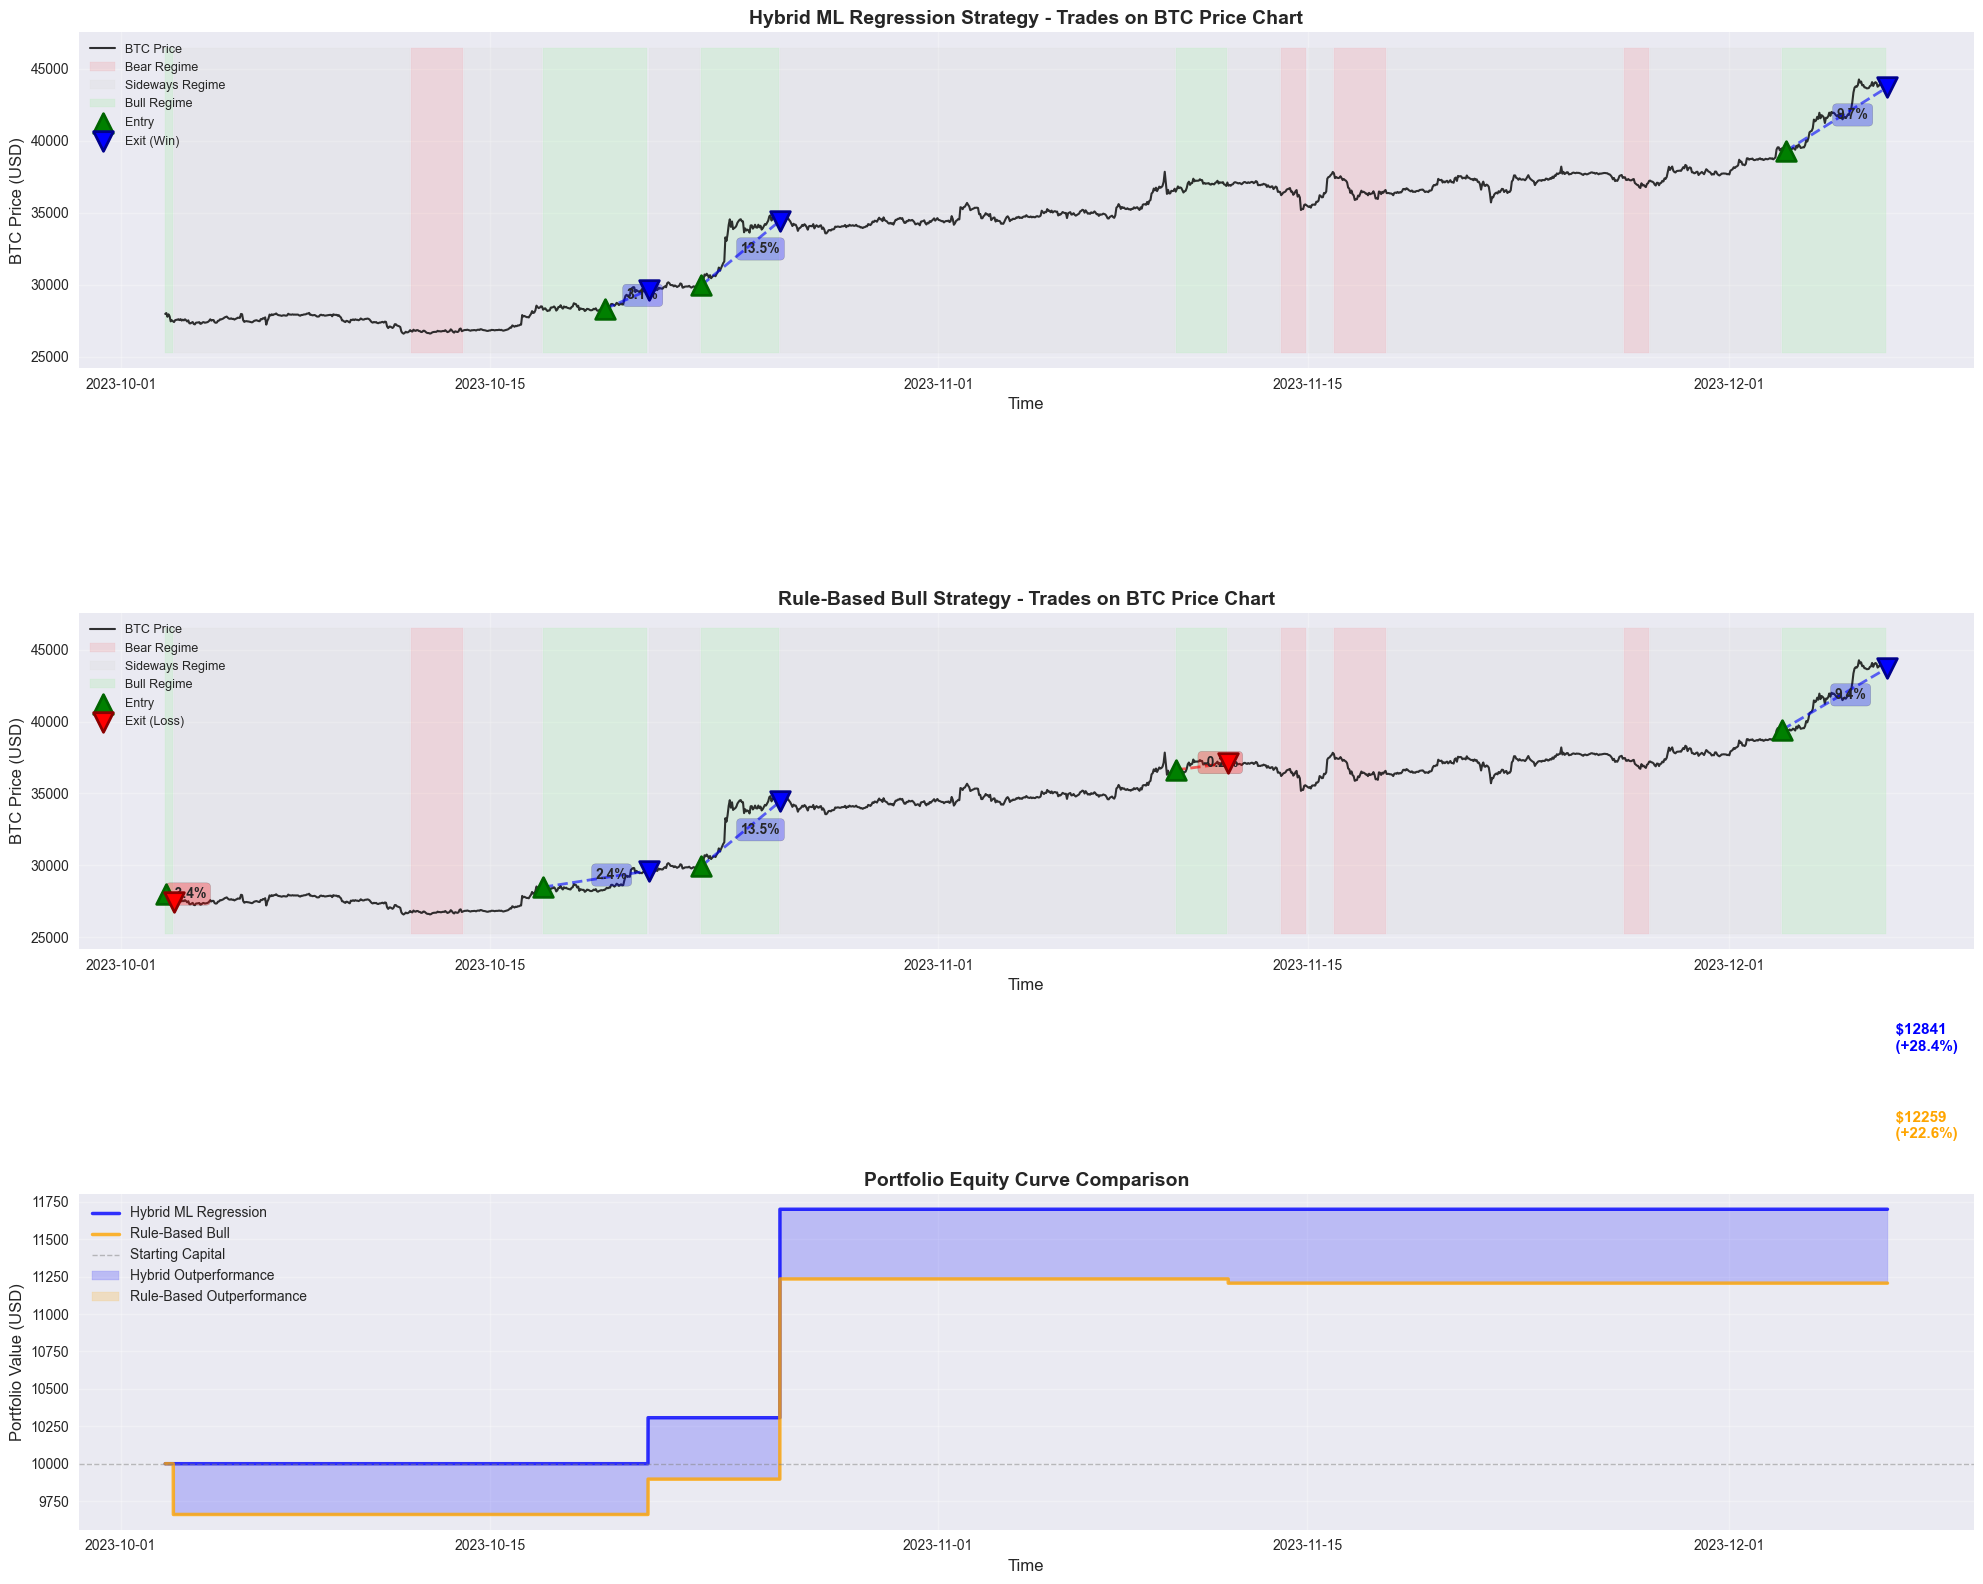


TRADE VISUALIZATION COMPLETE


In [25]:
# Create comprehensive trade visualization
fig, axes = plt.subplots(3, 1, figsize=(20, 16))

# Resample to hourly for cleaner visualization
df_hourly = df_backtest.resample('1H').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'regime': 'last'
}).dropna()

# Plot 1: BTC Price with Regime Background and Hybrid ML Trades
ax1 = axes[0]
ax1.plot(df_hourly.index, df_hourly['Close'], label='BTC Price', color='black', linewidth=1.5, alpha=0.8)

# Add regime background colors
regime_colors = {0: 'lightcoral', 1: 'lightgray', 2: 'lightgreen'}
regime_names = {0: 'Bear', 1: 'Sideways', 2: 'Bull'}

for regime_val in [0, 1, 2]:
    regime_mask = df_hourly['regime'] == regime_val
    if regime_mask.any():
        ax1.fill_between(df_hourly.index, 
                         df_hourly['Close'].min() * 0.95, 
                         df_hourly['Close'].max() * 1.05,
                         where=regime_mask,
                         alpha=0.2,
                         color=regime_colors[regime_val],
                         label=f'{regime_names[regime_val]} Regime')

# Plot Hybrid ML trades
if hybrid_results['num_trades'] > 0:
    hybrid_trades = pd.DataFrame(hybrid_results['trades'])
    for _, trade in hybrid_trades.iterrows():
        entry_time = trade['entry_time']
        exit_time = trade['exit_time']
        entry_price = trade['entry_price']
        exit_price = trade['exit_price']
        return_pct = trade['return_pct']
        
        # Entry marker
        ax1.scatter(entry_time, entry_price, color='green', marker='^', s=200, zorder=5, 
                   edgecolors='darkgreen', linewidths=2, label='Entry' if _ == 0 else '')
        
        # Exit marker
        color = 'blue' if return_pct > 0 else 'red'
        ax1.scatter(exit_time, exit_price, color=color, marker='v', s=200, zorder=5,
                   edgecolors='darkblue' if return_pct > 0 else 'darkred', linewidths=2,
                   label='Exit (Win)' if _ == 0 and return_pct > 0 else ('Exit (Loss)' if _ == 0 and return_pct <= 0 else ''))
        
        # Trade line
        ax1.plot([entry_time, exit_time], [entry_price, exit_price], 
                color=color, linestyle='--', linewidth=2, alpha=0.6)
        
        # Annotation
        mid_time = entry_time + (exit_time - entry_time) / 2
        mid_price = (entry_price + exit_price) / 2
        ax1.annotate(f'{return_pct:.1f}%', xy=(mid_time, mid_price),
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.3))

ax1.set_title('Hybrid ML Regression Strategy - Trades on BTC Price Chart', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('BTC Price (USD)', fontsize=12)
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: BTC Price with Rule-Based Trades
ax2 = axes[1]
ax2.plot(df_hourly.index, df_hourly['Close'], label='BTC Price', color='black', linewidth=1.5, alpha=0.8)

# Add regime background
for regime_val in [0, 1, 2]:
    regime_mask = df_hourly['regime'] == regime_val
    if regime_mask.any():
        ax2.fill_between(df_hourly.index, 
                         df_hourly['Close'].min() * 0.95, 
                         df_hourly['Close'].max() * 1.05,
                         where=regime_mask,
                         alpha=0.2,
                         color=regime_colors[regime_val],
                         label=f'{regime_names[regime_val]} Regime')

# Plot Rule-Based trades
if rulebased_results['num_trades'] > 0:
    rulebased_trades = pd.DataFrame(rulebased_results['trades'])
    for _, trade in rulebased_trades.iterrows():
        entry_time = trade['entry_time']
        exit_time = trade['exit_time']
        entry_price = trade['entry_price']
        exit_price = trade['exit_price']
        return_pct = trade['return_pct']
        
        # Entry marker
        ax2.scatter(entry_time, entry_price, color='green', marker='^', s=200, zorder=5,
                   edgecolors='darkgreen', linewidths=2, label='Entry' if _ == 0 else '')
        
        # Exit marker
        color = 'blue' if return_pct > 0 else 'red'
        ax2.scatter(exit_time, exit_price, color=color, marker='v', s=200, zorder=5,
                   edgecolors='darkblue' if return_pct > 0 else 'darkred', linewidths=2,
                   label='Exit (Win)' if _ == 0 and return_pct > 0 else ('Exit (Loss)' if _ == 0 and return_pct <= 0 else ''))
        
        # Trade line
        ax2.plot([entry_time, exit_time], [entry_price, exit_price],
                color=color, linestyle='--', linewidth=2, alpha=0.6)
        
        # Annotation
        mid_time = entry_time + (exit_time - entry_time) / 2
        mid_price = (entry_price + exit_price) / 2
        ax2.annotate(f'{return_pct:.1f}%', xy=(mid_time, mid_price),
                    fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.3))

ax2.set_title('Rule-Based Bull Strategy - Trades on BTC Price Chart', fontsize=14, fontweight='bold')
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('BTC Price (USD)', fontsize=12)
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

# Plot 3: Portfolio Equity Curves Comparison
ax3 = axes[2]

# Create time index for equity curves
time_index = df_backtest.index

# Plot equity curves
ax3.plot(time_index, hybrid_results['equity_curve'], label='Hybrid ML Regression', 
         color='blue', linewidth=2.5, alpha=0.8)
ax3.plot(time_index, rulebased_results['equity_curve'], label='Rule-Based Bull', 
         color='orange', linewidth=2.5, alpha=0.8)

# Add horizontal line at starting capital
ax3.axhline(y=10000, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Starting Capital')

# Fill area for outperformance
ax3.fill_between(time_index, 
                 hybrid_results['equity_curve'], 
                 rulebased_results['equity_curve'],
                 where=np.array(hybrid_results['equity_curve']) >= np.array(rulebased_results['equity_curve']),
                 alpha=0.2, color='blue', label='Hybrid Outperformance')
ax3.fill_between(time_index,
                 hybrid_results['equity_curve'],
                 rulebased_results['equity_curve'],
                 where=np.array(hybrid_results['equity_curve']) < np.array(rulebased_results['equity_curve']),
                 alpha=0.2, color='orange', label='Rule-Based Outperformance')

# Add final values as text
final_hybrid = hybrid_results['final_capital']
final_rulebased = rulebased_results['final_capital']
ax3.text(time_index[-1], final_hybrid, f'  ${final_hybrid:.0f}\n  (+{hybrid_results["total_return"]:.1f}%)',
         fontsize=11, fontweight='bold', color='blue', va='center')
ax3.text(time_index[-1], final_rulebased, f'  ${final_rulebased:.0f}\n  (+{rulebased_results["total_return"]:.1f}%)',
         fontsize=11, fontweight='bold', color='orange', va='center')

ax3.set_title('Portfolio Equity Curve Comparison', fontsize=14, fontweight='bold')
ax3.set_xlabel('Time', fontsize=12)
ax3.set_ylabel('Portfolio Value (USD)', fontsize=12)
ax3.legend(loc='upper left', fontsize=10)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hybrid_ml_regression_strategy_trades.png', dpi=150, bbox_inches='tight')
print("Visualization saved as: hybrid_ml_regression_strategy_trades.png")
plt.show()

print("\n" + "="*70)
print("TRADE VISUALIZATION COMPLETE")
print("="*70)